# Chains
- 処理を連鎖的に繋げる

## LLMChain
- 以下をつなぐ
    1. Prompt Template
    2. Language Model
    3. Output Parser

In [1]:
from langchain import LLMChain
from langchain_openai import ChatOpenAI
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from pydantic.v1 import BaseModel, Field

class Recipe(BaseModel):
    ingredients: list[str] = Field(description='材料')
    steps: list[str] = Field(description='手順')

# ★ 3.Output Parser
output_parser = PydanticOutputParser(pydantic_object=Recipe)

template = """
料理のレシピを教えてください。

{format_instruction}

料理名: {dish}
"""

# ★ 1.Prompt Template
prompt = PromptTemplate(
    template=template,
    input_variables=['dish'],
    partial_variables={'format_instruction': output_parser.get_format_instructions()},
)

# ★ 2.Language Model
chat = ChatOpenAI(
    model_name='gpt-3.5-turbo',
    temperature=0,
)

# ★　1~3をつなぐ
chain = LLMChain(
    prompt=prompt,
    llm=chat,
    output_parser=output_parser,
)

# 実行
recipe = chain.run(dish='カレー')
print(type(recipe))
print(recipe)

/usr/local/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


<class '__main__.Recipe'>
ingredients=['玉ねぎ', '人参', 'じゃがいも', '牛肉', 'カレールー', '水', '油'] steps=['1. 材料を準備する。', '2. 玉ねぎ、人参、じゃがいもを切る。', '3. 牛肉を炒める。', '4. 野菜を加えて炒める。', '5. 水を加えて煮込む。', '6. カレールーを溶かして加える。', '7. 煮込んで完成。']


## Simple Sequential Chain
- ChainとChainを直列につなぐ

In [2]:
from langchain import LLMChain
from langchain.chains import SimpleSequentialChain
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate

# LLM Modelは共通
chat = ChatOpenAI(
    model_name='gpt-3.5-turbo',
    temperature=0,
)

# -------------------------------------------------------------------
# Chain 1: Zero-shot CoT　でステップバイステップで考えさせる
# -------------------------------------------------------------------
cot_template = """
以下の質問に回答してください。

質問: {question}

ステップバイステップで考えましょう。
"""

cot_prompt = PromptTemplate(
    input_variables=['question'],
    template=cot_template,
)

cot_chain = LLMChain(prompt=cot_prompt, llm=chat)

# -------------------------------------------------------------------
# Chain 2: 要約させる
# -------------------------------------------------------------------
summarize_template = """
以下の文章を結論だけ一言で要約してください。

{input}
"""

summarize_prompt = PromptTemplate(
    input_variables=['input'],
    template=summarize_template,
)

summarize_chain = LLMChain(prompt=summarize_prompt, llm=chat)

# -------------------------------------------------------------------
# Chainを直列連結
# -------------------------------------------------------------------
chain = SimpleSequentialChain(
    chains=[cot_chain, summarize_chain]
)

# 質問文章
question = "私は市場に行って10個のリンゴを買いました。隣人に2つ、修理工に2つ渡しました。それから5つのリンゴを買って1つ食べました。残りは何個ですか？"

# 実行
result = chain(question)
print(result['output'])

/usr/local/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


残りのリンゴは10個。


In [3]:
# 結果は 'input' と　'output' をもつ辞書
result

{'input': '私は市場に行って10個のリンゴを買いました。隣人に2つ、修理工に2つ渡しました。それから5つのリンゴを買って1つ食べました。残りは何個ですか？',
 'output': '残りのリンゴは10個。'}

In [4]:
# 詳細出力
import langchain
langchain.verbose = True  # フォーマットされたプロンプトなどが表示される
langchain.debug = True  # LangChainの挙動が最も詳細に出力される

result = chain(question)
print(result['output'])

[chain/start] [1:chain:SimpleSequentialChain] Entering Chain run with input:
{
  "input": "私は市場に行って10個のリンゴを買いました。隣人に2つ、修理工に2つ渡しました。それから5つのリンゴを買って1つ食べました。残りは何個ですか？"
}
[chain/start] [1:chain:SimpleSequentialChain > 2:chain:LLMChain] Entering Chain run with input:
{
  "question": "私は市場に行って10個のリンゴを買いました。隣人に2つ、修理工に2つ渡しました。それから5つのリンゴを買って1つ食べました。残りは何個ですか？"
}
[llm/start] [1:chain:SimpleSequentialChain > 2:chain:LLMChain > 3:llm:ChatOpenAI] Entering LLM run with input:
{
  "prompts": [
    "Human: \n以下の質問に回答してください。\n\n質問: 私は市場に行って10個のリンゴを買いました。隣人に2つ、修理工に2つ渡しました。それから5つのリンゴを買って1つ食べました。残りは何個ですか？\n\nステップバイステップで考えましょう。"
  ]
}
[llm/end] [1:chain:SimpleSequentialChain > 2:chain:LLMChain > 3:llm:ChatOpenAI] [3.31s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "1. 最初に市場で10個のリンゴを買いました。\n2. 隣人に2つ、修理工に2つ渡しました。残りは10 - 2 - 2 = 6個です。\n3. その後、5つのリンゴを追加で購入しました。残りは6 + 5 = 11個です。\n4. 1つのリンゴを食べたので、残りは11 - 1 = 10個です。\n\nしたがって、残りのリンゴは10個です。",
        "generation_info": {
          

## Chain同士を接続するChain
| Chain                 | 概要                  |
| --------------------- | --------------------- |
| SimpleSequentialChain | 直列に接続            |
| SequentialChain       | 複数の入出力に対応    |
| LLMRouterChain        | LLMの判断で分岐を実現 |

## 特定のユースケースに特化したChain
| Chain                          | 概要                                                                |
| ------------------------------ | ------------------------------------------------------------------- |
| OpenAIModerationChain          | テキストがOpenAIの利用ポリシーに違反しないかチェック(OpenAIのModeration API利用)                                                                                                      |
| LLMRequestsChain               | 指定したURLにHTTPリクエストを送信し、レスポンスの内容を踏まえてLLMに質問回答させる                                                                                                    |
| OpenAPIEndpointChain           | 自然言語で入力を与えると、OpenAPI仕様(Swagger)をもとにLLMがAPIへのリクエストを生成し、その内容でAPIを呼び出す。さらに、APIからのレスポンスを踏まえてLLMに質問回答させることもできる。 |
| PAL Chain(Experimental)        | 自然言語の入力をもとにLLMがプログラムを生成し、プログラムを実行した結果を返す。「PAL: Program-aided Language Models」という論文に基づく実装                                           |
| SQLDatabaseChain(Experimental) | 自然言語の入力をもとにLLMがSQLを生成し、DBに対して実行した上で最終的な回答を出力させる |


※Experimental: 実験的な実装。langchain_experimental パッケージに入っている。

## 【オプション】LLMRequestsChainを試してみる
- 指定したURLにHTTPリクエストを送信し、レスポンスの内容を踏まえてLLMに質問回答させる
- 知識生成プロンプティングの一種？？

In [5]:
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain, LLMRequestsChain

# プロンプト
template = """
以下の>>>と<<<の間の文章はWebサイトから取得したデータです。
質問"{question}"に対する回答を抽出してください。もし適切な回答が見つからない場合は「回答が見つかりません。」と出力してください。
>>> {requests_result} <<<
Answer:
"""

prompt = PromptTemplate(
    input_variables=['question', 'requests_result'],
    template=template,
)

# モデル
chat = ChatOpenAI(
    model_name='gpt-3.5-turbo',
    temperature=0,
)

# Chain生成
chain = LLMRequestsChain(
    llm_chain=LLMChain(prompt=prompt, llm=chat, verbose=False),
    verbose=False,
)

# 実行
question = 'ゲーム「パルワールド」の概要を教えて'
result = chain(dict(
    question=question,
    url='https://www.pocketpair.jp/palworld?lang=ja',
))

result

[chain/start] [1:chain:LLMRequestsChain] Entering Chain run with input:
{
  "question": "ゲーム「パルワールド」の概要を教えて",
  "url": "https://www.pocketpair.jp/palworld?lang=ja"
}
[chain/start] [1:chain:LLMRequestsChain > 2:chain:LLMChain] Entering Chain run with input:
{
  "question": "ゲーム「パルワールド」の概要を教えて",
  "requests_result": "\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPalworld | Pocketpair,Inc.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\ntop of page採用情報ニュース会社概要パルワールドNever GraveクラフトピアAIアートインポスターオーバーダンジョンMoreUse tab to navigate through the menu items.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nDiscord\n\n\n\n\n\n\n\nYoutube\n\n\n\n\n\nX\n\n\n\n\n\ntiktok\n\n\n\n\n\n大好評発売中!!動画を再生動画を再生03:06Palworld | Early Access Launch Trailer | Pocketpair動画を再生動画を再生02:00Paldeck_SP | No.050 JETRAGON - Palworld | Gameplay | Pocketpair動画を再生動画を再生02:50Palworld｜HOW TO RAISE THE STRONGEST PALS｜ 

{'question': 'ゲーム「パルワールド」の概要を教えて',
 'url': 'https://www.pocketpair.jp/palworld?lang=ja',
 'output': 'パルワールドは、100種類以上の個性豊かなパルたちが登場し、プレイヤーを待ち受けています。プレイヤーはパルを捕獲し、育成し、拠点建築を行いながら、他のプレイヤーと協力したり対立したりすることができます。パルたちは独自の特技や属性を持ち、戦闘や労働を通じて活躍します。'}

In [6]:
for k, v in result.items():
    sep = '-'*30
    print(sep + k + sep)
    print(v)

------------------------------question------------------------------
ゲーム「パルワールド」の概要を教えて
------------------------------url------------------------------
https://www.pocketpair.jp/palworld?lang=ja
------------------------------output------------------------------
パルワールドは、100種類以上の個性豊かなパルたちが登場し、プレイヤーを待ち受けています。プレイヤーはパルを捕獲し、育成し、拠点建築を行いながら、他のプレイヤーと協力したり対立したりすることができます。パルたちは独自の特技や属性を持ち、戦闘や労働を通じて活躍します。


---
#### ChatGPTに普通に聞いたらこんな回答
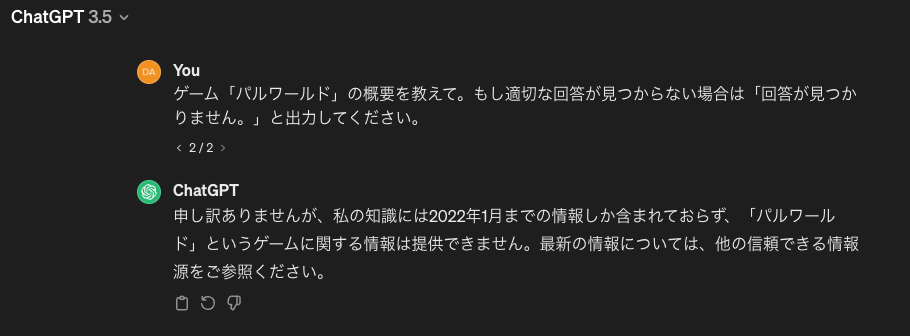